In [1]:
import os
import re
import shutil
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf
import unicodedata
import urllib3
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [2]:
num_samples = 33000

# 1. 정제, 정규화, 전처리 

In [3]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
      if unicodedata.category(c) != 'Mn')

In [4]:
def preprocess_sentence(sent):
    # 위에서 구현한 함수를 내부적으로 호출
    sent = unicode_to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백을 만듭니다.
    # Ex) "he is a boy." => "he is a boy ."
    sent = re.sub(r"([?.!,¿])", r" \1", sent)

    # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
    sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

    sent = re.sub(r"\s+", " ", sent)
    return sent

In [5]:
def load_preprocessed_data():
    encoder_input, decoder_input, decoder_target = [], [], []

    file_path = os.getenv('HOME') + '/aiffel/translator_seq2seq/data/fra.txt'

    with open(file_path, "r") as lines:
        for i, line in enumerate(lines):

            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line_input = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            # 시작, 종료 토큰 넣기
            tar_line_input = [w for w in ("<sos> " + tar_line).split()]
            tar_line_target = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line_input)
            decoder_input.append(tar_line_input)
            decoder_target.append(tar_line_target)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [6]:
sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data()
print(sents_en_in[:5])
print(sents_fra_in[:5])
print(sents_fra_out[:5])

[['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.']]
[['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!']]
[['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>']]


# 2. 토크나이저 (word to index)

In [7]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)
decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

In [8]:
encoder_input = pad_sequences(encoder_input, padding="post")
decoder_input = pad_sequences(decoder_input, padding="post")
decoder_target = pad_sequences(decoder_target, padding="post")

In [10]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4672, 프랑스어 단어 집합의 크기 : 8137


In [11]:
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word # 훈련 후 결과 비교할 때 사용

tar_to_index = tokenizer_fra.word_index # 훈련 후 예측 과정에서 사용
index_to_tar = tokenizer_fra.index_word # 훈련 후 결과 비교할 때 사용

In [12]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[ 9320 12232 25453 ... 12268 31402  7778]


In [13]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [14]:
n_of_val = 3000 #33000개 중 3000개를 테스트 데이터로 분리

In [15]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [16]:
print(encoder_input_train.shape)
print(decoder_input_train.shape)
print(decoder_target_train.shape)
print(encoder_input_test.shape)
print(decoder_input_test.shape)
print(decoder_target_test.shape)

(30000, 8)
(30000, 16)
(30000, 16)
(3000, 8)
(3000, 16)
(3000, 16)


In [17]:
latent_dim = 50

# 3. Embedding layer, Modeling

In [19]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb =  Embedding(src_vocab_size, latent_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(latent_dim, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [20]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, latent_dim) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [21]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [22]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [23]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     233600      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     406850      input_2[0][0]                    
______________________________________________________________________________________________

In [30]:
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 128, epochs = 50)

Epoch 1/50
235/235 [==============================] - 6s 27ms/step - loss: 0.6163 - acc: 0.8946 - val_loss: 0.8386 - val_acc: 0.8642
Epoch 2/50
235/235 [==============================] - 6s 26ms/step - loss: 0.6115 - acc: 0.8951 - val_loss: 0.8366 - val_acc: 0.8656
Epoch 3/50
235/235 [==============================] - 6s 26ms/step - loss: 0.6076 - acc: 0.8960 - val_loss: 0.8354 - val_acc: 0.8657
Epoch 4/50
235/235 [==============================] - 6s 26ms/step - loss: 0.6037 - acc: 0.8968 - val_loss: 0.8350 - val_acc: 0.8661
Epoch 5/50
235/235 [==============================] - 6s 26ms/step - loss: 0.6000 - acc: 0.8975 - val_loss: 0.8372 - val_acc: 0.8650
Epoch 6/50
235/235 [==============================] - 6s 26ms/step - loss: 0.5968 - acc: 0.8982 - val_loss: 0.8347 - val_acc: 0.8661
Epoch 7/50
235/235 [==============================] - 6s 26ms/step - loss: 0.5933 - acc: 0.8989 - val_loss: 0.8333 - val_acc: 0.8662
Epoch 8/50
235/235 [==============================] - 6s 26ms/step - 

In [31]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)

In [32]:
# 디코더
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2= dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

In [33]:
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

In [34]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    states_value = encoder_model.predict(input_seq)

    # <SOS>에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

         # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [35]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2src(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + index_to_src[i]+' '
    return temp

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2tar(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_to_index['<sos>']) and i!=tar_to_index['<eos>']):
            temp = temp + index_to_tar[i] + ' '
    return temp

# 4. 모델평가

In [41]:
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_train[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("원문 : ",seq2src(encoder_input_train[seq_index]))
    print("번역 :",seq2tar(decoder_input_train[seq_index]))
    print("예측 :",decoded_sentence[:-5])
    print("\n")

원문 :  i was late . 
번역 : j etais en retard . 
예측 :  j etais en retard . 


원문 :  he s love struck . 
번역 : il a le coup de foudre . 
예측 :  il le chapeau . 


원문 :  does tom smoke ? 
번역 : tom fume t il ? 
예측 :  est ce que tom a mange ? 


원문 :  they re all guilty . 
번역 : ils sont tous coupables . 
예측 :  ils sont toutes froid . 


원문 :  it looks nice . 
번역 : ca a l air bien . 
예측 :  ca a l air bien . 




In [39]:
for seq_index in [3,50,100,300,1001]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)

    print("원문 : ",seq2src(encoder_input_test[seq_index]))
    print("번역 :",seq2tar(decoder_input_test[seq_index]))
    print("예측 :",decoded_sentence[:-5])
    print("\n")

원문 :  it s not right . 
번역 : c est inexact . 
예측 :  ce n est pas a la raison . 


원문 :  what s your wish ? 
번역 : quel est votre souhait ? 
예측 :  quel est votre fils ? 


원문 :  thanks a lot . 
번역 : merci mille fois ! 
예측 :  merci bien . 


원문 :  we count on you . 
번역 : nous comptons sur vous . 
예측 :  nous ne pouvons pas en . 


원문 :  take it easy ! 
번역 : relaxe max ! 
예측 :  ne votre calme ! 




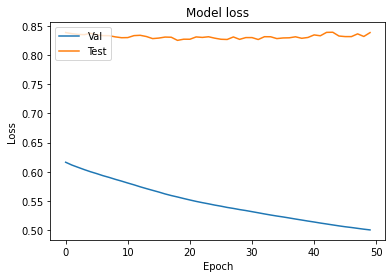

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Val', 'Test'], loc='upper left')
plt.show()

# 5. 회고

세상 제일 어려웠던 노드.. 여러자료를 찾아보고 개념은 이해했지만, 코드에서 막혔다. character로 토큰한것을 파라미터값만 지우면 word로 쉽사리 될 것이라고 생각했는데, 중간중간 에러가 떠서 해결이 힘들었다. 참고자료를 보며 복붙하기밖에 안된 것 같아 속상 ㅠㅠㅠㅠ
그래프계형은 test에서 loss 가 train보다는 훨씬 높았지만 번역결과는 잘나왔다.
참고 : https://wikidocs.net/86900

#### 결과 해석값

it s not right  / ce n est pas a la raison. / 그것은 논리가 아니다

what s your wish ? / quel est votre fils ? / 당신의 아들은 무엇입니까?

thanks a lot . / merci bien . / 감사합니다.

we count on you ./ nous ne pouvons pas en ./ 우리는 할 수 없습니다.

take it easy ! / ne votre calme ! / 진정하세요!